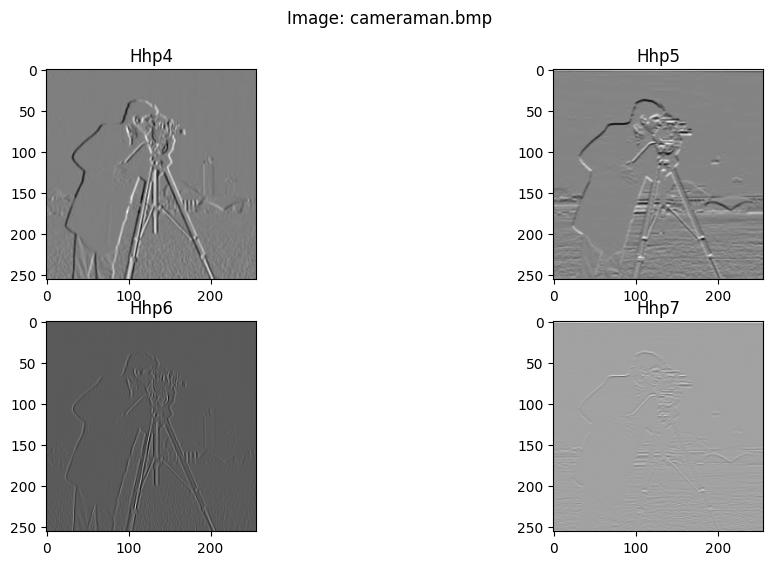

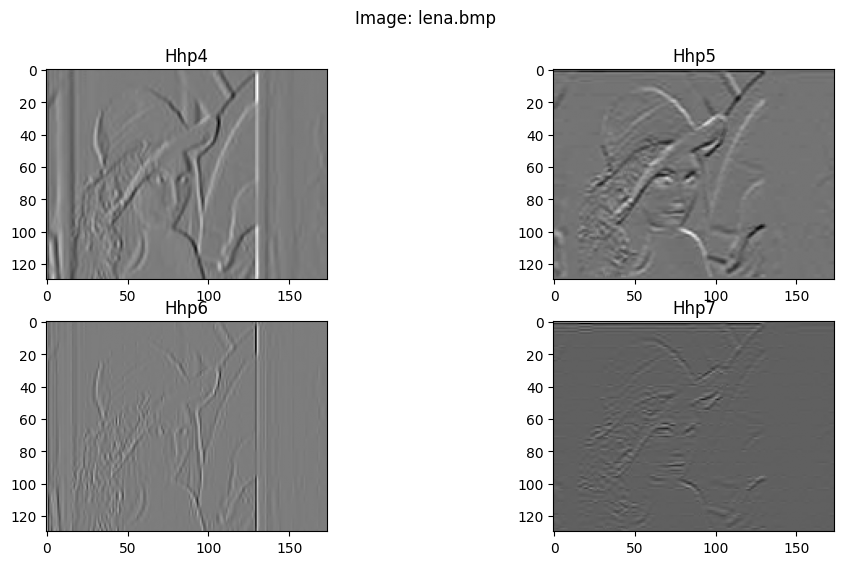

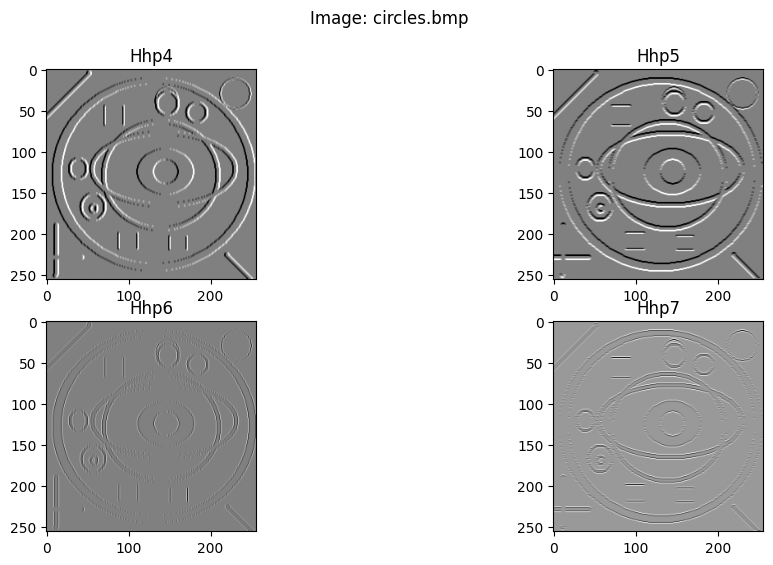

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_paths = ['cameraman.bmp', 'lena.bmp', 'circles.bmp']
filters = {
    'Hhp4': np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]),    # لبه‌های عمودی
    'Hhp5': np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]),   # لبه‌های افقی
    'Hhp6': np.array([[-1, 2, -1], [-1, 2, -1], [-1, 2, -1]]),# تقویت لبه عمودی
    'Hhp7': np.array([[-1, -1, -1], [2, 2, 2], [-1, -1, -1]]) # تقویت لبه افقی
}

for path in image_paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Image: {path}')

    for i, (name, kernel) in enumerate(filters.items(), 1):
        filtered = cv2.filter2D(img.astype('float32'), -1, kernel)
        plt.subplot(2, 2, i)
        plt.imshow(filtered, cmap='gray')
        plt.title(name)
    plt.show()

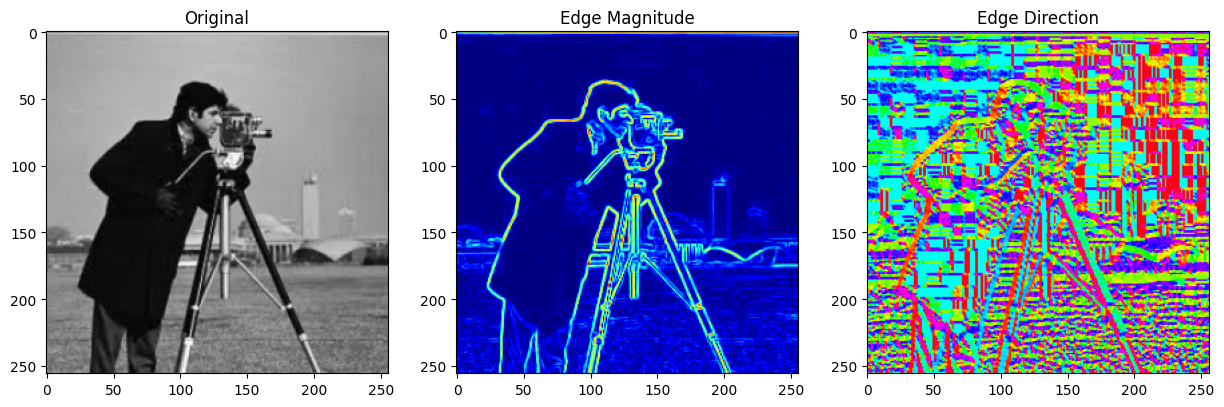

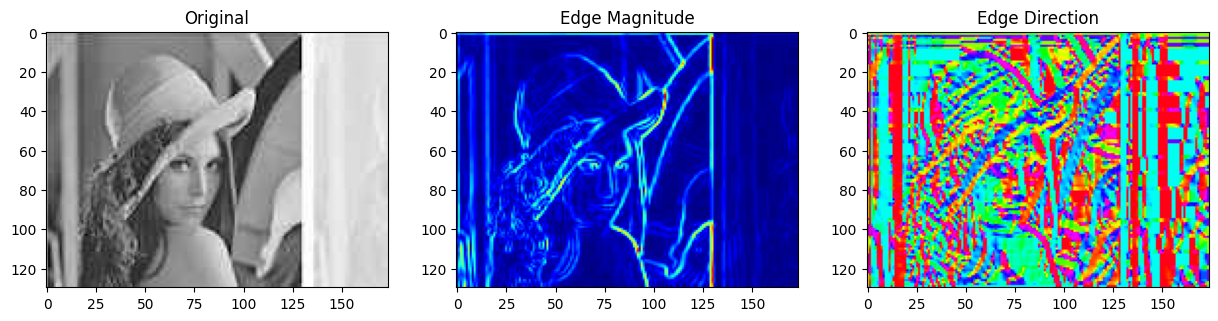

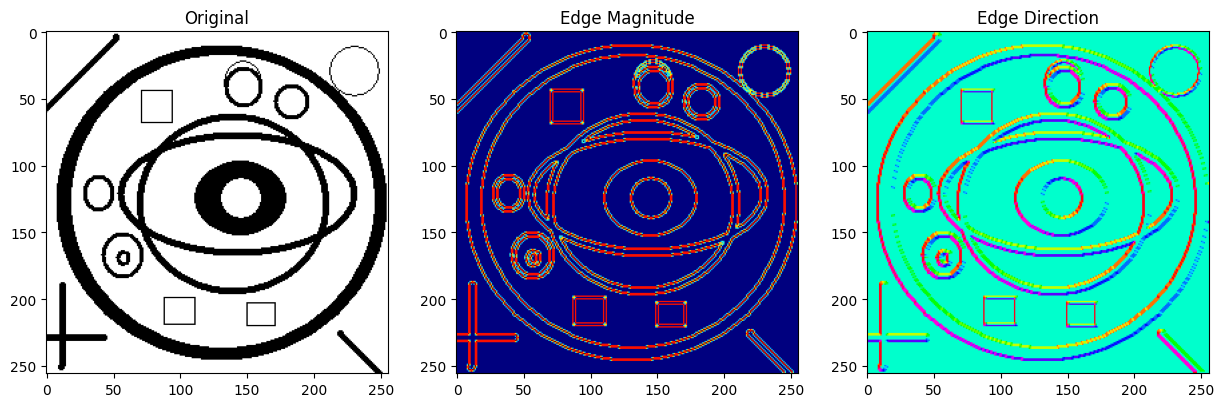

In [ ]:
for path in image_paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    direction = np.arctan2(sobel_y, sobel_x) * 180 / np.pi

    plt.figure(figsize=(15, 5))
    plt.subplot(131), plt.imshow(img, cmap='gray'), plt.title('Original')
    plt.subplot(132), plt.imshow(magnitude, cmap='jet'), plt.title('Edge Magnitude')
    plt.subplot(133), plt.imshow(direction, cmap='hsv'), plt.title('Edge Direction')
    plt.show()

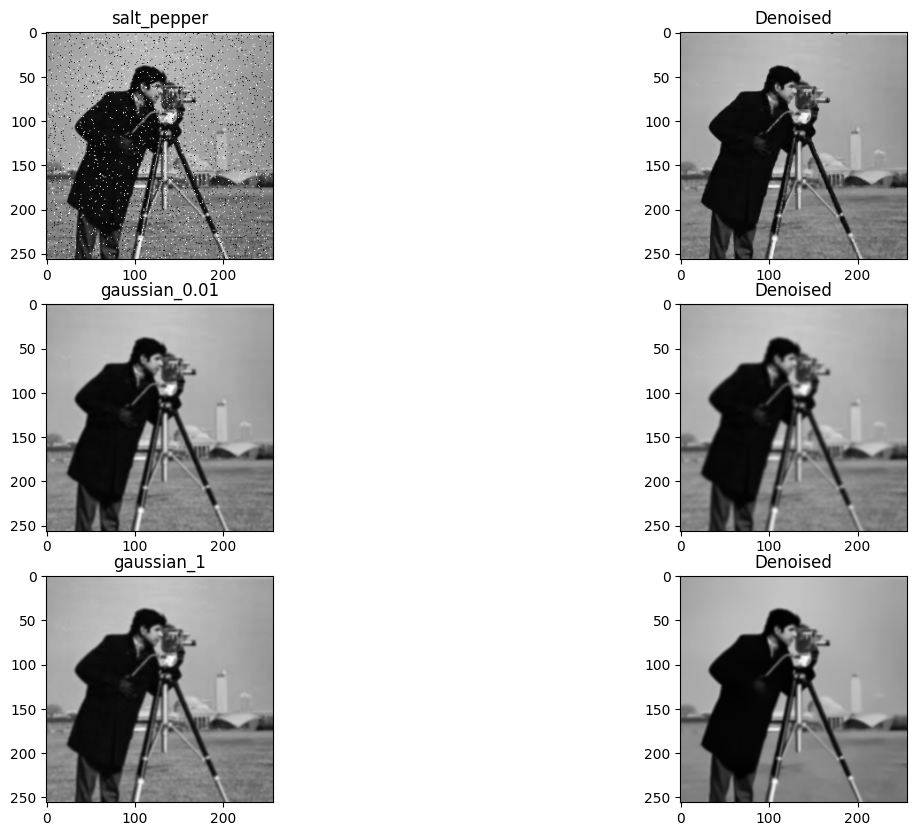

In [ ]:
def add_salt_pepper(image, prob=0.05):
    output = np.copy(image)
    salt = np.random.rand(*image.shape) < prob/2
    pepper = np.random.rand(*image.shape) < prob/2
    output[salt] = 255
    output[pepper] = 0
    return output

img = cv2.imread('cameraman.bmp', cv2.IMREAD_GRAYSCALE)

noisy = {
    'salt_pepper': add_salt_pepper(img),
    'gaussian_0.01': cv2.GaussianBlur(img, (5,5), 0) + np.random.normal(0, 0.01, img.shape),
    'gaussian_1': cv2.GaussianBlur(img, (5,5), 0) + np.random.normal(0, 1, img.shape)
}

plt.figure(figsize=(15, 10))
for i, (name, noisy_img) in enumerate(noisy.items(), 1):
    plt.subplot(3, 2, i*2-1)
    plt.imshow(noisy_img, cmap='gray')
    plt.title(name)

    if 'salt' in name:
        denoised = cv2.medianBlur(noisy_img.astype('uint8'), 3)
    elif '0.01' in name:
        denoised = cv2.GaussianBlur(noisy_img, (5,5), 0)
    else:
        denoised = cv2.fastNlMeansDenoising(noisy_img.astype('uint8'), None, 10, 7, 21)

    plt.subplot(3, 2, i*2)
    plt.imshow(denoised, cmap='gray')
    plt.title('Denoised')
plt.show()

In [ ]:
pip install opencv-python numpy matplotlib

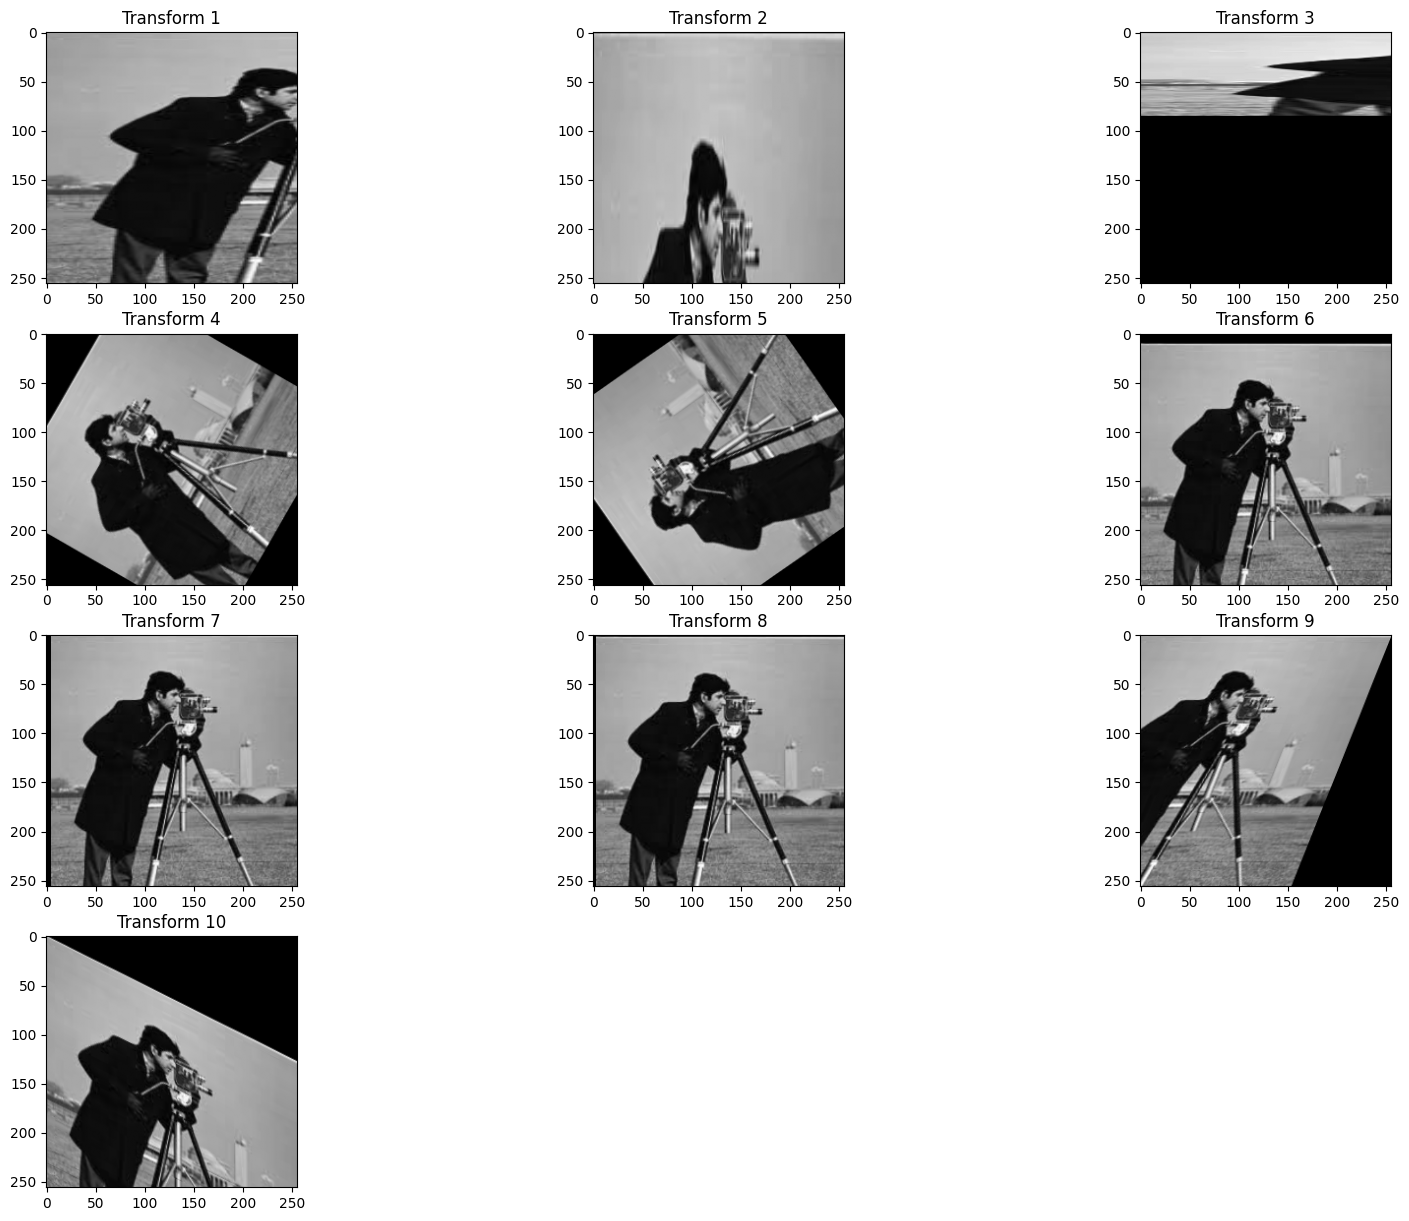

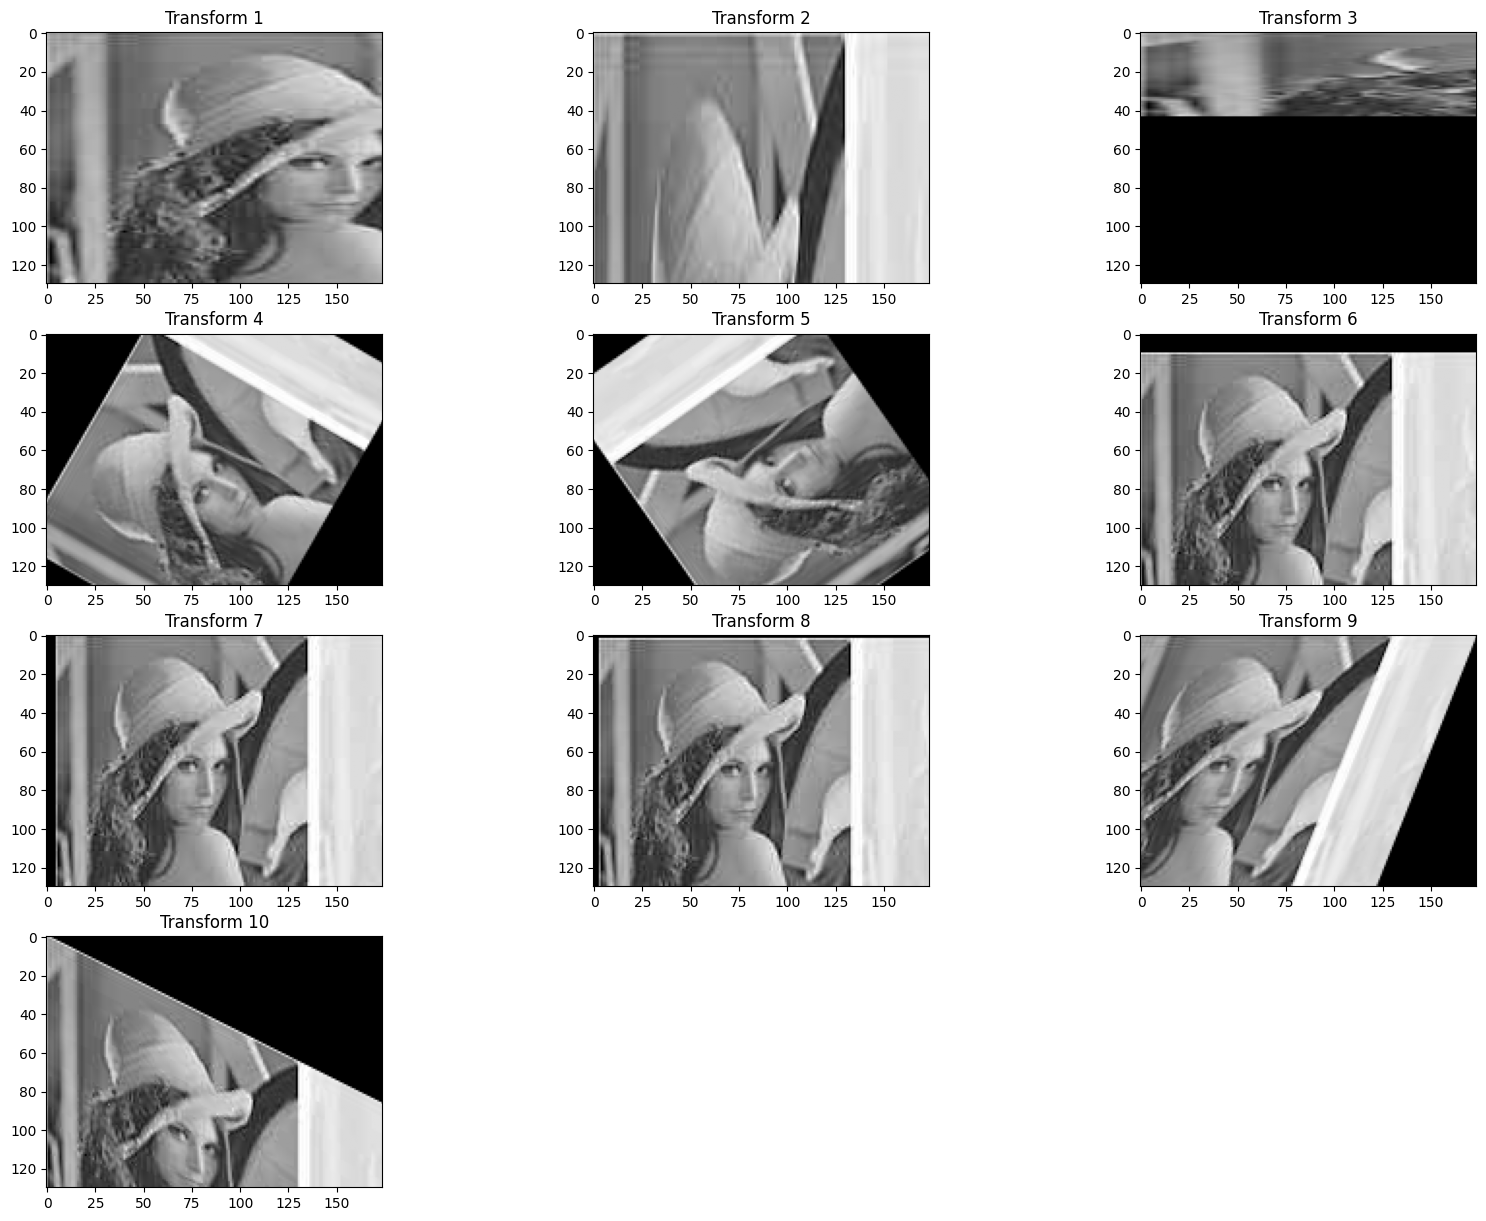

In [ ]:
for path in image_paths[:2]:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    rows, cols = img.shape
    plt.figure(figsize=(20, 15))

    transforms = [
        np.float32([[2, 0, 0], [0, 1, 0]]),            # Scale X=2
        np.float32([[1, 0, 0], [0, 3, 0]]),            # Scale Y=3
        np.float32([[4, 0, 0], [0, 1/3, 0]]),          # Scale X=4, Y=1/3
        cv2.getRotationMatrix2D((cols/2, rows/2), 60, 1),  # Rotation 60°
        cv2.getRotationMatrix2D((cols/2, rows/2), 125, 1), # Rotation 125°
        np.float32([[1, 0, 0], [0, 1, 10]]),           # Translate Y=10
        np.float32([[1, 0, 5], [0, 1, 0]]),            # Translate X=5
        np.float32([[1, 0, 3], [0, 1, 2]]),            # Translate X=3,Y=2
        np.float32([[1, -0.4, 0], [0, 1, 0]]),         # Shear X
        np.float32([[1, 0, 0], [0.5, 1, 0]])           # Shear Y
    ]

    for i, trans in enumerate(transforms, 1):
        result = cv2.warpAffine(img, trans, (cols, rows))
        plt.subplot(4, 3, i)
        plt.imshow(result, cmap='gray')
        plt.title(f'Transform {i}')
    plt.show()

Filter Center: (256, 256)
Filter Size: 512x512


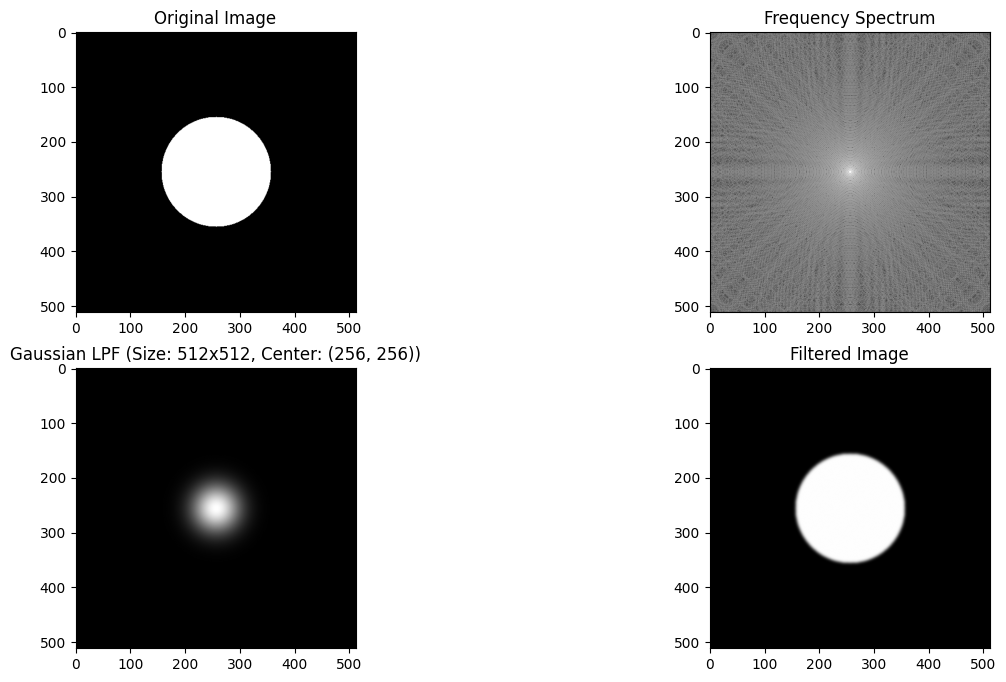

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

M, N = 512, 512
image = np.zeros((M, N), dtype=np.uint8)
cv2.circle(image, (N//2, M//2), 100, 255, -1)

dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

D0 = 30
center = (M//2, N//2)
print(f"Filter Center: {center}")
print(f"Filter Size: {M}x{N}")

H = np.zeros((M, N, 2), dtype=np.float32)
for u in range(M):
    for v in range(N):
        D = np.sqrt((u - center[0])**2 + (v - center[1])**2)
        H[u, v] = np.exp(-D**2 / (2 * D0**2))

filtered_shift = dft_shift * H
filtered = np.fft.ifftshift(filtered_shift)
img_filtered = cv2.idft(filtered, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)
img_filtered = cv2.normalize(img_filtered, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

plt.figure(figsize=(15, 8))
plt.subplot(221), plt.imshow(image, cmap='gray'), plt.title('Original Image')
plt.subplot(222), plt.imshow(np.log(1 + cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1])), cmap='gray'), plt.title('Frequency Spectrum')
plt.subplot(223), plt.imshow(H[:,:,0], cmap='gray'), plt.title(f'Gaussian LPF (Size: {M}x{N}, Center: {center})')
plt.subplot(224), plt.imshow(img_filtered, cmap='gray'), plt.title('Filtered Image')
plt.show()

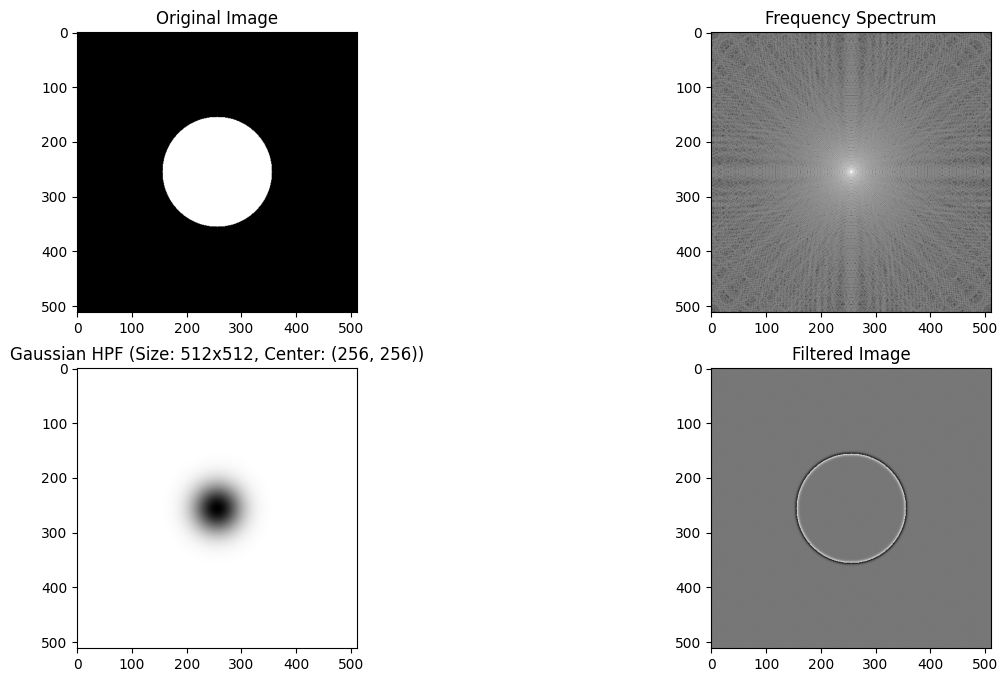

In [ ]:
# Create Gaussian HPF
H_high = 1 - H

filtered_shift = dft_shift * H_high
filtered = np.fft.ifftshift(filtered_shift)
img_highpass = cv2.idft(filtered, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)
img_highpass = cv2.normalize(img_highpass, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

plt.figure(figsize=(15, 8))
plt.subplot(221), plt.imshow(image, cmap='gray'), plt.title('Original Image')
plt.subplot(222), plt.imshow(np.log(1 + cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1])), cmap='gray'), plt.title('Frequency Spectrum')
plt.subplot(223), plt.imshow(H_high[:,:,0], cmap='gray'), plt.title(f'Gaussian HPF (Size: {M}x{N}, Center: {center})')
plt.subplot(224), plt.imshow(img_highpass, cmap='gray'), plt.title('Filtered Image')
plt.show()

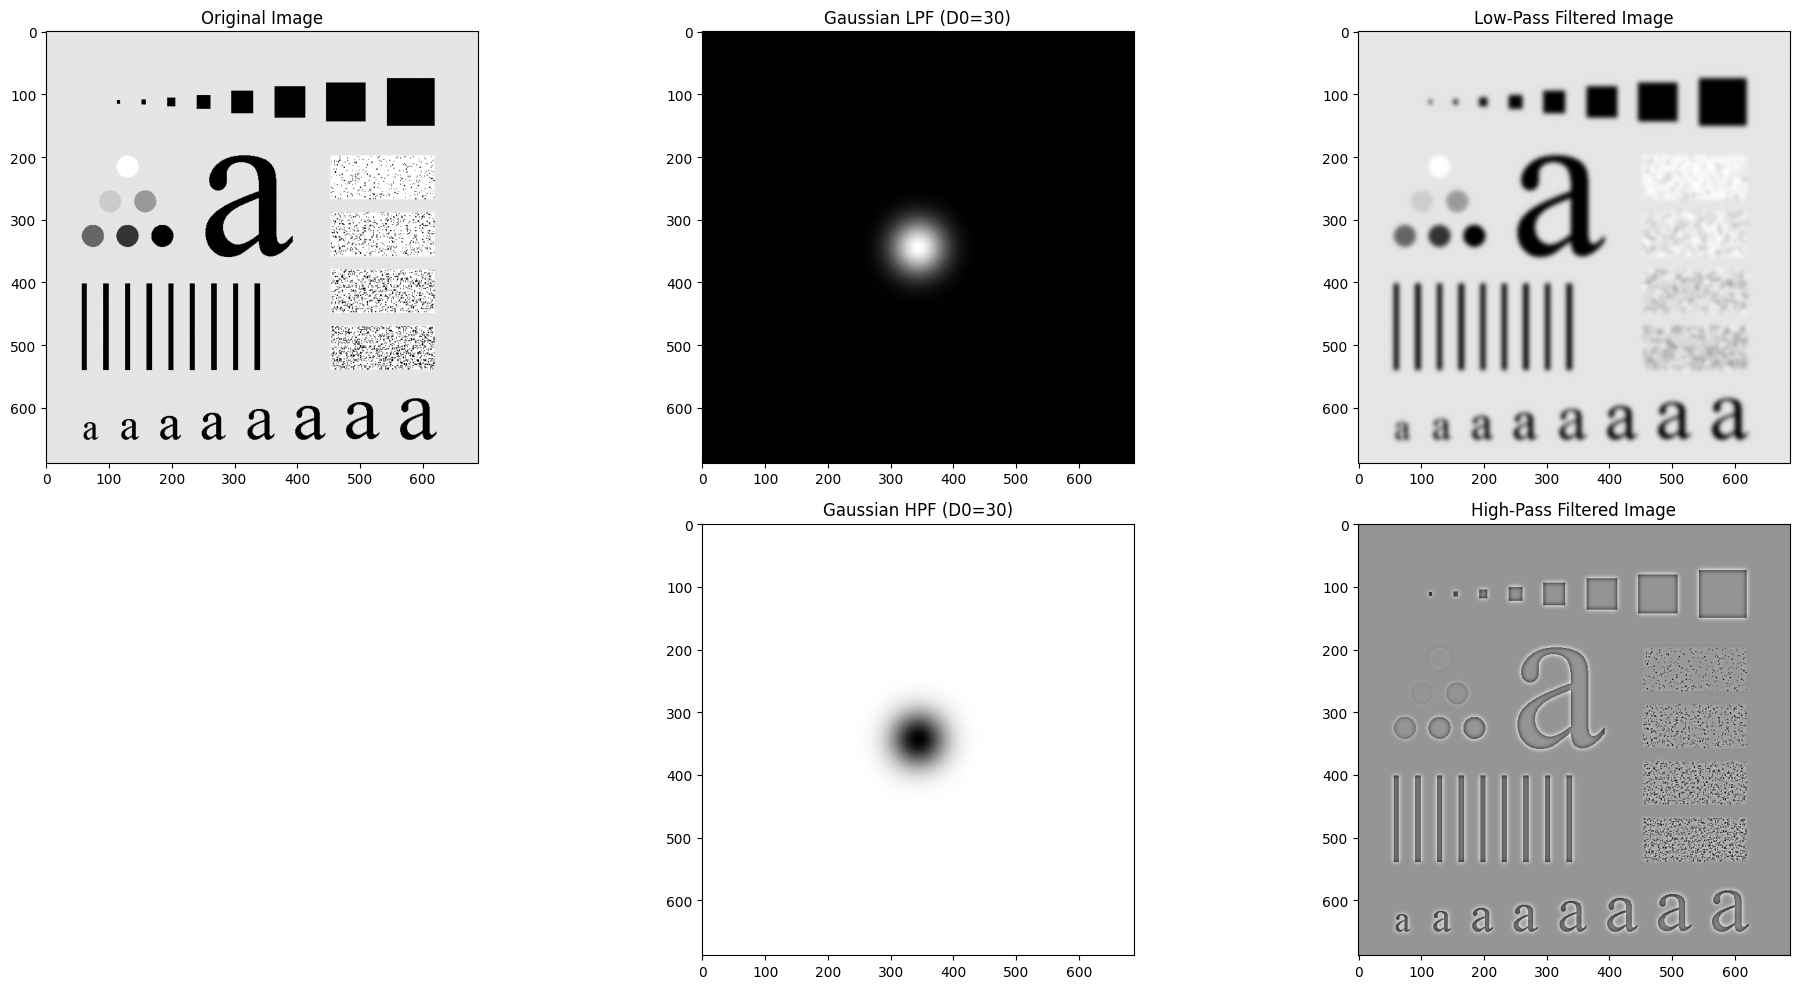

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def gaussian_lowpass_filter(img, D0=30):
    M, N = img.shape
    H = np.zeros((M, N), dtype=np.float32)
    center = (M//2, N//2)

    for u in range(M):
        for v in range(N):
            D = np.sqrt((u - center[0])**2 + (v - center[1])**2)
            H[u, v] = np.exp(-D**2 / (2 * D0**2))

    return H

def gaussian_highpass_filter(img, D0=30):
    H_low = gaussian_lowpass_filter(img, D0)
    H_high = 1 - H_low
    return H_high

def apply_filter(img, H):
    dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    H_complex = np.zeros((img.shape[0], img.shape[1], 2), dtype=np.float32)
    H_complex[:, :, 0] = H
    H_complex[:, :, 1] = H

    filtered_shift = dft_shift * H_complex
    filtered = np.fft.ifftshift(filtered_shift)
    img_back = cv2.idft(filtered, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)
    img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    return img_back


image = cv2.imread('Fig4.41(a).tif', cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError("File 'Fig4.41(a).tif' not found!")

H_low = gaussian_lowpass_filter(image, D0=30)
H_high = gaussian_highpass_filter(image, D0=30)

lowpass_img = apply_filter(image, H_low)
highpass_img = apply_filter(image, H_high)

plt.figure(figsize=(20, 10))

plt.subplot(231), plt.imshow(image, cmap='gray'), plt.title('Original Image')
plt.subplot(232), plt.imshow(H_low, cmap='gray'), plt.title('Gaussian LPF (D0=30)')
plt.subplot(233), plt.imshow(lowpass_img, cmap='gray'), plt.title('Low-Pass Filtered Image')
plt.subplot(235), plt.imshow(H_high, cmap='gray'), plt.title('Gaussian HPF (D0=30)')
plt.subplot(236), plt.imshow(highpass_img, cmap='gray'), plt.title('High-Pass Filtered Image')

plt.tight_layout()
plt.show()